## Initial Imports and image loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [8]:
ROOT = '/content/drive/MyDrive/GitHub/DigitisingChess'
%cd DigitisingChess/

/content/drive/MyDrive/GitHub/DigitisingChess


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Read the image
# img = cv2.imread('chess images/IMG_20211010_151046.jpg')
img = cv2.imread('testImg/testImg.png')

In [10]:
print('Original Dimensions: ', img.shape)

Original Dimensions:  (481, 696, 3)


In [ ]:
# cv2.imshow('original', img)
# cv2.waitKey(0)

In [11]:
sml_img = img

## Set up image

In [ ]:
# # Resize image
# scale_percent = 10
# width = int(img.shape[1] * scale_percent / 100)
# height = int(img.shape[0] * scale_percent / 100)
# dim = (width, height)

# sml_img = cv2.resize(img, dim)
# print('Resized Dimensions: ', sml_img.shape)

In [ ]:
# cv2.imshow('Resized', sml_img)
# cv2.waitKey(0)

In [12]:
# Convert to grayscale
img_gray = cv2.cvtColor(sml_img, cv2.COLOR_BGR2GRAY)

In [13]:
# Blur image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)

## Prewitt filter

In [14]:
# prewitt
kernelx_0 = np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
img_prewittx_0 = cv2.filter2D(img_blur, -1, kernelx_0)

kernelx_1 = np.array([[-1,-1,-1], [0,0,0], [1,1,1]])
img_prewittx_1 = cv2.filter2D(img_blur, -1, kernelx_1)


kernely_0 = np.array([[-1,0,1], [-1,0,1], [-1,0,1]])
img_prewitty_0 = cv2.filter2D(img_blur, -1, kernely_0)

kernely_1 = np.array([[1,0,-1], [1,0,-1], [1,0,-1]])
img_prewitty_1 = cv2.filter2D(img_blur, -1, kernely_1)



# img_prewitt = img_prewittx + img_prewitty

# img_prewitt = np.sqrt((img_prewittx * img_prewittx) + (img_prewitty * img_prewitty))

img_prewittx = img_prewittx_0 + img_prewittx_1
img_prewitty = img_prewitty_0 + img_prewitty_1



img_prewitt = np.hypot(img_prewittx, img_prewitty)
img_prewitt = img_prewitt / img_prewitt.max() * 255
img_prewitt = img_prewitt.astype('uint8')

theta = np.arctan2(img_prewitty, img_prewittx).astype('uint8')

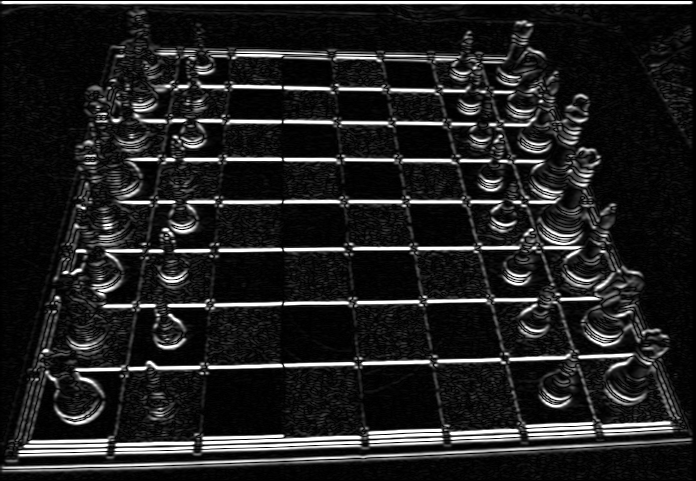

-1

In [18]:
from google.colab.patches import cv2_imshow

cv2_imshow(img_prewittx)
# cv2_imshow("Prewitt X_1", img_prewittx_1)
# cv2_imshow("Prewitt Y", img_prewitty)
# cv2_imshow("Prewitt Y_1", img_prewitty_1)

# cv2.imshow("Prewitt", img_prewitt)

cv2.waitKey(0)

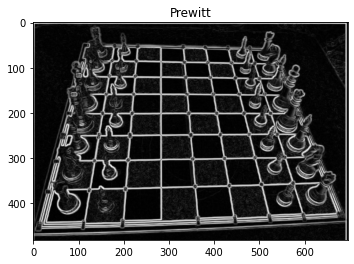

In [19]:
plt.imshow(img_prewitt, cmap=plt.cm.Greys_r)
plt.title("Prewitt")
plt.show()

In [ ]:
# from scipy import ndimage

# Kx = np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
# Ky = np.array([[-1,0,1], [-1,0,1], [-1,0,1]])

# Ix = ndimage.filters.convolve(img_blur, Kx)
# Iy = ndimage.filters.convolve(img_blur, Ky)


# # prewitt1 = np.sqrt((Ix * Ix) + (Iy * Iy))
# prewitt1 = np.hypot(Ix, Iy)

# prewitt1 = prewitt1 / prewitt1.max() * 255
# prewitt1 = prewitt1.astype('uint8')


In [ ]:
# # cv2.imshow("Prewitt X", Ix)
# # cv2.imshow("Prewitt Y", Iy)
# cv2.imshow("Prewitt", prewitt1)

# cv2.waitKey(0)

## Canny Algorithm
- non-maximal suppression applied to reduce weak edges 
- hysteresis thresholding omitted to maximize the number of line pixels. 

In [ ]:
# img_canny = cv2.Canny(img_prewitt, 0, 0)

In [ ]:
# cv2.imshow("Canny", img_canny)
# cv2.waitKey(0)

In [ ]:
def non_max_suppression(img, D):
    width, height = img.shape
    returnImg = np.zeros((width,height), dtype=np.uint8)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,width-1):
        for j in range(1,height-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    returnImg[i,j] = img[i,j]
                else:
                    returnImg[i,j] = 0

            except IndexError as e:
                pass
    
    return returnImg    

In [ ]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.uint8)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [ ]:
def myCanny(img, theta):
    res = non_max_suppression(img, theta)
    res, weak, strong = threshold(res)
    return res

In [ ]:
img_canny = myCanny(img_prewitt, theta)

# img_canny = non_max_suppression(img_prewitt, theta)
# print(img_canny)

# cv2.imshow("Canny", img_canny)
# cv2.waitKey(0)

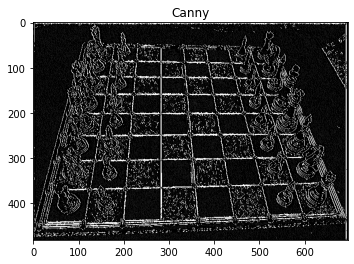

In [ ]:
plt.imshow(img_canny, cmap=plt.cm.Greys_r)
plt.title("Canny")
plt.show()

## Radon transform
- compute the Radon transform over 360° (Note that the matrix actually repeats after 180° but flipped vertically). 

In [ ]:
from skimage.transform import radon

# theta1 = np.linspace(0., 180., max(img_canny.shape), endpoint=False)
theta1 = np.linspace(0., 360., max(img_canny.shape),endpoint=False)
sinogram = radon(img_canny, theta=theta1, circle=False)

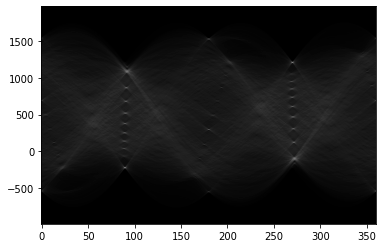

In [ ]:
import matplotlib.pyplot as plt

dx, dy = 0.5 * 360.0 / max(img_canny.shape), sinogram.shape[0]
plt.imshow(sinogram, cmap=plt.cm.Greys_r,extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')
#plt.imshow(sinogram, 'gray',extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

plt.show()


In [ ]:
sinogram

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Determine the general direction of the lines in the image

apply simple threshold based on the standard deviation


In [ ]:
stdDev = np.std(sinogram)

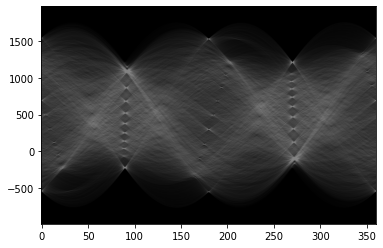

In [ ]:
ret,bestLinePoints1 = cv2.threshold(sinogram, 100 + stdDev,255,cv2.THRESH_TRUNC)
plt.imshow(bestLinePoints1,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

In [ ]:
print(stdDev)

32.381688928627284


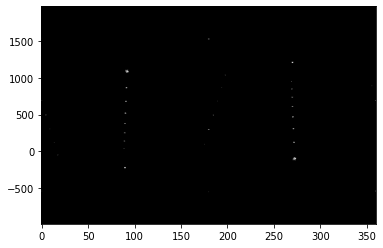

In [ ]:

ret,bestLinePoints2 = cv2.threshold(sinogram, 170+stdDev,255,cv2.THRESH_BINARY)
plt.imshow(bestLinePoints2,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

In [ ]:
print(len(bestLinePoints2))

985


In [ ]:
def findPeaks(matrix):
    localPeaks = []

    for i in range(1, (len(matrix) -1)):
        for j in range(1, (len(matrix[0]) -1)):        
            # for each element, if it is greater than all its neighbours, add it to list

            # check vertical neighbours first
            if (compareNeighbours(matrix, i, j, 3)):
                localPeaks.append([j,i])

    return localPeaks

In [ ]:
def compareNeighbours(matrix, x, y, radius = 3):
    for i in range(1, radius+1):
        if not ((matrix[x][y] > matrix[x][y+i]) and (matrix[x][y] > matrix[x][y-i]) and (matrix[x][y] > matrix[x+i][y]) and (matrix[x][y] > matrix[x-i][y]) and (matrix[x][y] > matrix[x+i][y+i]) and (matrix[x][y] > matrix[x-i][y+i]) and (matrix[x][y] > matrix[x-i][y-i])and (matrix[x][y] > matrix[x+i][y-i])):
            return False
                       
    return True

In [ ]:
localPeaks = findPeaks(bestLinePoints2)
print(len(localPeaks))
print(localPeaks)

7
[[687, 360], [375, 368], [366, 429], [18, 555], [27, 616], [339, 624], [348, 839]]


In [ ]:
points = []

for i in range(len(bestLinePoints2)):
    for j in range(len(bestLinePoints2[0])):
        if bestLinePoints2[i][j] > 254:
            points.append([j,i])

print(len(points))

250


In [ ]:
points2 = sorted(points, key=lambda x: x[0])
print(points2)

[[0, 145], [0, 426], [0, 427], [0, 835], [0, 836], [1, 426], [1, 427], [1, 835], [1, 836], [9, 492], [10, 491], [10, 492], [18, 555], [27, 616], [34, 673], [35, 672], [172, 573], [172, 609], [172, 610], [172, 643], [172, 644], [173, 530], [173, 531], [173, 572], [173, 573], [173, 609], [173, 610], [173, 728], [173, 729], [173, 730], [173, 731], [173, 732], [174, 482], [174, 483], [174, 484], [174, 485], [174, 530], [174, 531], [174, 572], [174, 573], [174, 610], [174, 728], [174, 729], [174, 730], [174, 731], [175, 289], [175, 290], [175, 294], [175, 429], [175, 430], [175, 431], [175, 482], [175, 483], [175, 484], [175, 530], [175, 531], [175, 573], [175, 728], [175, 729], [175, 730], [175, 731], [175, 732], [176, 292], [176, 293], [176, 296], [176, 297], [176, 368], [176, 369], [176, 370], [176, 429], [176, 430], [176, 431], [176, 483], [176, 484], [176, 485], [177, 289], [177, 290], [177, 293], [177, 294], [177, 295], [177, 298], [177, 299], [177, 368], [177, 369], [177, 370], [177,

In [ ]:
points_limited = []
for i in range(len(points2)):
    if points2[i][1] > 200 and points2[i][1] < 700:
        points_limited.append(points2[i])

print(len(points_limited))
print(points_limited)

222
[[521, 252], [523, 252], [521, 253], [522, 253], [523, 253], [521, 254], [522, 254], [523, 254], [521, 255], [522, 255], [523, 255], [521, 256], [522, 256], [523, 256], [180, 288], [175, 289], [177, 289], [179, 289], [175, 290], [177, 290], [178, 290], [179, 290], [178, 291], [179, 291], [176, 292], [180, 292], [176, 293], [177, 293], [180, 293], [175, 294], [177, 294], [179, 294], [180, 294], [181, 294], [177, 295], [178, 295], [179, 295], [180, 295], [181, 295], [176, 296], [178, 296], [179, 296], [180, 296], [176, 297], [178, 297], [180, 297], [181, 297], [177, 298], [178, 298], [179, 298], [180, 298], [181, 298], [177, 299], [178, 299], [179, 299], [178, 300], [382, 311], [383, 312], [520, 340], [520, 341], [687, 360], [178, 367], [176, 368], [177, 368], [178, 368], [375, 368], [176, 369], [177, 369], [178, 369], [176, 370], [177, 370], [178, 370], [520, 374], [521, 374], [522, 374], [520, 375], [521, 375], [520, 411], [521, 411], [522, 411], [523, 411], [521, 412], [522, 412],

In [ ]:
points3 = sorted(localPeaks, key=lambda x: x[0])
print(points3)

[[41, 729], [42, 727], [105, 538], [108, 515], [109, 528], [168, 278], [170, 277], [171, 279], [320, 765], [389, 255], [390, 257], [453, 446], [456, 469], [457, 456], [516, 706], [518, 707], [519, 705], [668, 219]]


C:\Users\samra\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\samra\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3441: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


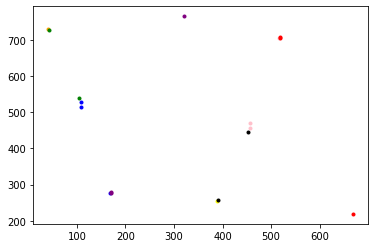

In [ ]:
# prevX = 0
# count = 0

# colorArr = ['red', 'orange', 'green', 'blue', 'purple', 'yellow', 'black', 'pink']
# lineArr = []
# xArr = np.array([])
# yArr = np.array([])

# for (x, y) in points3:
# # for (x, y) in points3:
#     xArr = np.append(xArr, x)
#     yArr = np.append(yArr, y)
    
#     # xArr.append(x)
#     # yArr.append(y)
#     if x > (prevX+35):
#         m, b = np.polyfit(xArr, yArr, 1)

#         count+= 1        
#         if count > 7:
#             count = 0
        
#         # plt.plot(xArr, m*xArr + b)
#         plt.plot(xArr, yArr, '.', c=colorArr[count])
#         # plt.plot(xArr, yArr, '.', c="black")

#         lineArr.append([xArr, yArr])
#         xArr = np.array([])
#         yArr = np.array([])

#     prevX = x
    

# plt.show()

In [ ]:
prevX = 0
count = 0

_points = points_limited

colorArr = ['red', 'orange', 'green', 'blue', 'purple', 'yellow', 'black', 'pink']
lineArr = []
gradientsArr = []
xArr = np.array([])
yArr = np.array([])
(x,y) = _points[0]

counter = 0
while counter < len(_points):
	while x < (prevX+40):
		prevX = x

		xArr = np.append(xArr, x)
		yArr = np.append(yArr, y)
		
		counter += 1

		if counter > (len(_points)-1):
			break

		(x,y) = _points[counter]

	prevX = x
	# get gradient and y-intercept for line of best fit
	m, b = np.polyfit(xArr, yArr, 1)
	gradientsArr.append([m,b])

	# plot points and lines
	plt.plot(xArr, m*xArr + b, c=colorArr[count])
	plt.plot(xArr, yArr, '.', c=colorArr[count])

	lineArr.append([xArr, yArr])
	xArr = np.array([])
	yArr = np.array([])

	count+= 1        
	if count > 7:
		count = 0

		

plt.show()

TypeError: expected non-empty vector for x

In [ ]:
def drawLinesOntop(image, arrGradient, arrLines):
    m = 0
    b = 0
    xArr = []
    yArr = []

    plt.imshow(image, cmap=plt.cm.Greys_r, aspect='auto')
    # plt.imshow(bestLinePoints,'gray',vmin=0,vmax=255, aspect='auto')

    for i in range(len(arrGradient)):
        m,b = arrGradient[i]
        xArr, yArr = arrLines[i]
        plt.plot(xArr, m*xArr + b)


    plt.show()

In [ ]:
def scatterOnTop(image, coords):
    plt.imshow(image, cmap=plt.cm.Greys_r, aspect='auto')

    for x,y in coords:
        plt.scatter(x,y, c="green", marker='.')

    plt.show()

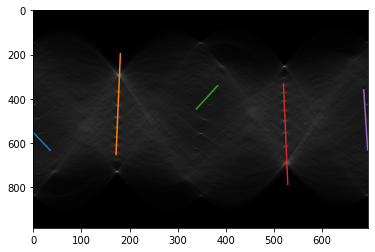

In [ ]:

# m = 0
# b = 0
# xArr = []
# yArr = []

# plt.imshow(sinogram, cmap=plt.cm.Greys_r, aspect='auto')
# # plt.imshow(bestLinePoints,'gray',vmin=0,vmax=255, aspect='auto')

# for i in range(len(gradientsArr)):
# 	m,b = gradientsArr[i]
# 	xArr, yArr = lineArr[i]
# 	plt.plot(xArr, m*xArr + b)


# plt.show()
	
drawLinesOntop(sinogram, gradientsArr, lineArr)


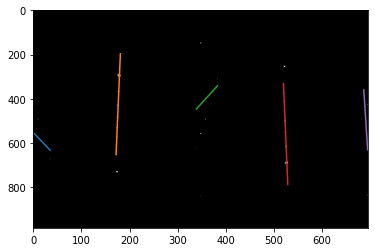

In [ ]:
drawLinesOntop(bestLinePoints2, gradientsArr, lineArr)

## calculate second derivative along these cross-sections 

In [ ]:
# sinogram
# gradientsArr
# lineArr

X_green = lineArr[2][0]
X_red = lineArr[3][0]

Y_green = (gradientsArr[2][0] * X_green) + gradientsArr[2][1]
Y_red = (gradientsArr[3][0] * X_red) + gradientsArr[3][1]

len(X_green)

IndexError: list index out of range

In [ ]:
def getSinoVals(X_arr, Y_arr, sinogram):
    sino_vals = []

    for i in range(len(X_arr)):
        locX = round(X_arr[i])
        locY = round(Y_arr[i])
        # print(locX, locY)

        sino_vals.append(sinogram[locX][locY])

    return sino_vals
    

In [ ]:
# green_sino_vals = getSinoVals(X_green, Y_green, sinogram)
# red_sino_vals = getSinoVals(X_red, Y_red, sinogram)

In [ ]:

from scipy.ndimage import laplace 

second_derivative_abs = np.abs(laplace(sinogram))
print(second_derivative_abs)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
ret,betterSecondDeriv = cv2.threshold(second_derivative_abs, 120,255,cv2.THRESH_BINARY)
plt.imshow(betterSecondDeriv,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

NameError: name 'second_derivative_abs' is not defined

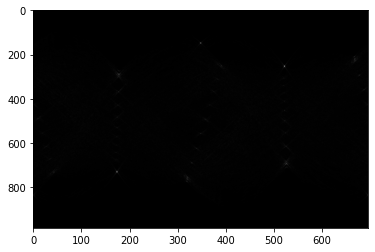

In [ ]:
drawLinesOntop(second_derivative_abs, [], [])

### extract the second derivative from the cross section

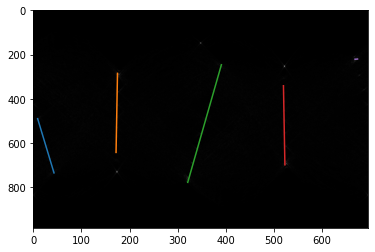

In [ ]:
drawLinesOntop(second_derivative_abs, gradientsArr, lineArr)

In [ ]:
X_green = lineArr[2][0]
X_red = lineArr[3][0]

Y_green = (gradientsArr[2][0] * X_green) + gradientsArr[2][1]
Y_red = (gradientsArr[3][0] * X_red) + gradientsArr[3][1]
print(X_green)
print(Y_green)

[321. 326. 357. 375. 390. 390. 391.]
[778.67828059 740.61313267 504.60921554 367.57468302 253.37923925
 253.37923925 245.76620967]


In [ ]:
def pointsOnLine(gradient, y_intercept, xMax, xMin, yMax, yMin):
    x0 = (yMin-y_intercept)/ gradient
    coords = []

    for x in range(xMin, xMax, 1):
        y = int((gradient*x) + y_intercept)
        if y > yMax or y < yMin:
            break
        
        coords.append([x,y])

    if coords == []:
        for y in range(yMin, yMax, 1):
            x = int((y - y_intercept) / gradient)
            if x > xMax or x < xMin:
                break
            coords.append([x,y])
    
    return coords

In [ ]:
imageShape = second_derivative_abs.shape

print(imageShape[1])

greenCoords = pointsOnLine(gradientsArr[2][0], gradientsArr[2][1], imageShape[0], 0, imageShape[1], 0)

print(greenCoords)

696
[[423, 0], [423, 1], [423, 2], [422, 3], [422, 4], [422, 5], [422, 6], [422, 7], [422, 8], [422, 9], [421, 10], [421, 11], [421, 12], [421, 13], [421, 14], [421, 15], [421, 16], [421, 17], [420, 18], [420, 19], [420, 20], [420, 21], [420, 22], [420, 23], [420, 24], [419, 25], [419, 26], [419, 27], [419, 28], [419, 29], [419, 30], [419, 31], [419, 32], [418, 33], [418, 34], [418, 35], [418, 36], [418, 37], [418, 38], [418, 39], [418, 40], [417, 41], [417, 42], [417, 43], [417, 44], [417, 45], [417, 46], [417, 47], [416, 48], [416, 49], [416, 50], [416, 51], [416, 52], [416, 53], [416, 54], [416, 55], [415, 56], [415, 57], [415, 58], [415, 59], [415, 60], [415, 61], [415, 62], [415, 63], [414, 64], [414, 65], [414, 66], [414, 67], [414, 68], [414, 69], [414, 70], [413, 71], [413, 72], [413, 73], [413, 74], [413, 75], [413, 76], [413, 77], [413, 78], [412, 79], [412, 80], [412, 81], [412, 82], [412, 83], [412, 84], [412, 85], [411, 86], [411, 87], [411, 88], [411, 89], [411, 90], [411

In [ ]:
def getValuesFromImage(pointsOnLine, image):
    image_vals = np.array([])
    # gradient = gradientsArr[2][0] 
    # y_intercept = gradientsArr[2][1]

    # x0 = (-y_intercept)/ gradient

    # for i in range(len(X_arr)):
    #     locX = round(X_arr[i])
    #     locY = round(Y_arr[i])
    #     # print(locX, locY)

    for x,y in pointsOnLine:
        # image_vals = np.append(image_vals, image[locX][locY])
        image_vals = np.append(image_vals, image[x][y])

    return image_vals
    

In [ ]:
# greenSecDeriv = getValuesFromImage(X_green, Y_green, second_derivative_abs)
imageShape = second_derivative_abs.shape

greenSecDeriv = getValuesFromImage(pointsOnLine(gradientsArr[2][0], gradientsArr[2][1], imageShape[0], 0, imageShape[1], 0), second_derivative_abs)

print(greenSecDeriv)

[6.34721027e+00 5.21210474e+00 7.15531538e+01 5.40491935e+01
 2.91132152e+00 2.50633876e+01 6.56576983e+01 8.59129338e+00
 5.27180369e+00 2.82772222e+01 1.08888435e+01 1.70724217e+01
 3.97383184e+00 4.00194697e+00 4.60938149e-01 2.96007384e+00
 1.13776749e+01 8.95525880e-01 1.66420909e+01 4.26503364e+00
 4.84892302e+00 1.94693406e+01 2.84537054e+01 9.36051642e+00
 7.99563043e+00 3.55054073e+00 1.72655412e+01 7.63589203e+00
 1.20674547e+01 1.01705795e+01 1.36057844e+01 1.74886931e-02
 8.62919667e+00 2.02191478e+01 5.27595270e+01 6.10899771e+01
 1.47553035e+01 3.30191540e+00 7.52485048e+00 7.33322238e+00
 1.17785229e+01 1.42979916e+01 3.44781034e+01 3.88323631e+01
 7.25453847e+00 1.00653354e+01 1.43167179e+01 7.92091102e+00
 2.99860814e+00 1.48416647e+01 3.38443649e+01 3.86033256e+01
 4.00924848e+01 2.14956076e+01 3.47550600e+01 4.26377227e+01
 2.60251013e+01 3.33352460e+01 1.24359536e+01 5.09978899e+00
 2.40837702e+01 2.23041877e+01 1.68458634e+00 3.97298270e+01
 7.03175011e-01 3.434534

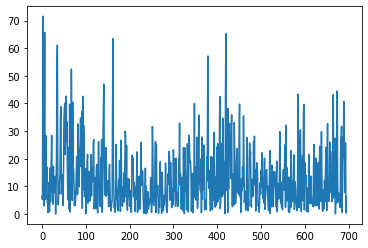

In [ ]:
plt.plot(greenSecDeriv)

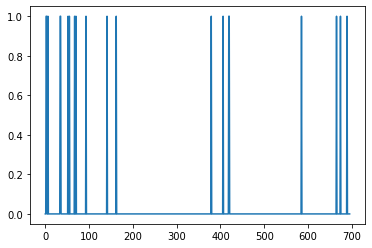

In [ ]:
ret,greenPeaks = cv2.threshold(greenSecDeriv, 40,1,cv2.THRESH_BINARY)
plt.plot(greenPeaks)
# print(greenPeaks)
#plt.imshow(greenPeaks,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

In [ ]:
# get index of all elements that are '1'. These are the x-coords. Use the pointsOnLine output to determine y-coords
# use x and y coords to find locations of corners

indexList = []

for i in range(len(greenPeaks)):
    if greenPeaks[i] == 1:
        indexList.append(i)

print(indexList)

[2, 3, 6, 34, 35, 52, 55, 67, 70, 93, 141, 162, 379, 406, 419, 420, 585, 665, 674, 689]


In [ ]:
peakCoords = []
for i in indexList:
    peakCoords.append(greenCoords[i])

print(peakCoords)

[[423, 2], [422, 3], [422, 6], [418, 34], [418, 35], [416, 52], [416, 55], [414, 67], [414, 70], [411, 93], [404, 141], [402, 162], [373, 379], [369, 406], [368, 419], [368, 420], [346, 585], [335, 665], [334, 674], [332, 689]]


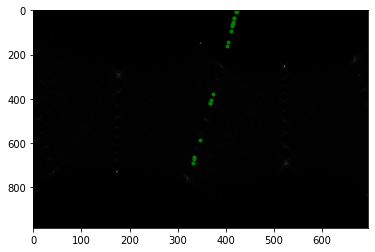

In [ ]:
scatterOnTop(second_derivative_abs, peakCoords)


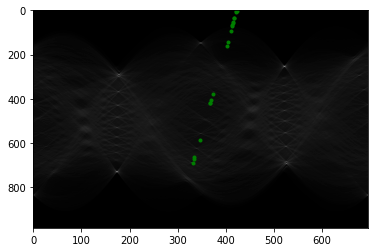

In [ ]:
scatterOnTop(sinogram, peakCoords)

In [ ]:
corners = np.zeros(sinogram.shape)

for x,y in peakCoords:
    corners[x][y] = 1

In [ ]:
# greenPeakCoords = []

# for i in range(len(greenPeaks)):
# 	if greenPeaks[i] == 1:
# 		greenPeakCoords.append([X_green[i], Y_green[i]])

# print(greenPeakCoords)

## Reconstruction with Filtered Back Projection

In [ ]:
from skimage.transform import iradon

theta2 = np.linspace(0., 360., max(img_canny.shape), endpoint=False)


reconstruction_fbp = iradon(sinogram, theta=theta2, filter_name='cosine', circle=False)
# error = reconstruction_fbp - img_canny
# print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

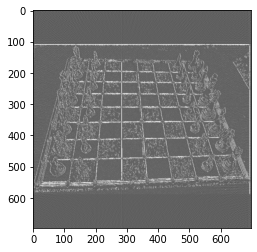

In [ ]:
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
# plt.imshow(reconstruction_fbp, vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

In [ ]:
reconstruction_fbp = iradon(second_derivative_abs, theta=theta2, filter_name='cosine', circle=False)
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)

NameError: name 'second_derivative_abs' is not defined

In [ ]:
# betterSecondDeriv
reconstruction_fbp = iradon(betterSecondDeriv, theta=theta2, filter_name='cosine', circle=False)
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)

NameError: name 'betterSecondDeriv' is not defined

In [ ]:
print(reconstruction_fbp.max)

<built-in method max of numpy.ndarray object at 0x000001F5004471B0>


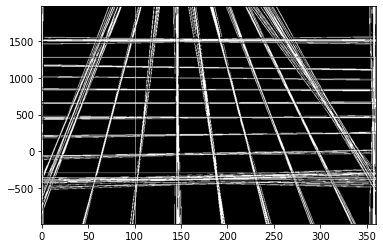

In [ ]:
ret, testImg = cv2.threshold(reconstruction_fbp, 0.015,255,cv2.THRESH_BINARY)
plt.imshow(testImg,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

In [ ]:
print(reconstruction_fbp)

[[-0.00062348 -0.00073726 -0.00063434 ...  0.16176281  0.24863368
  -0.01010781]
 [-0.00058924 -0.00068485 -0.00058897 ...  0.1657644   0.25319103
  -0.01649645]
 [-0.00068356 -0.00071478 -0.00067639 ...  0.16973108  0.2576569
  -0.02291964]
 ...
 [-0.07612498  0.21903807 -0.01265461 ...  0.22576019  0.03672671
  -0.16953888]
 [-0.02950921  0.22054864 -0.04840216 ...  0.22221389  0.03482766
  -0.16415707]
 [ 0.03896639  0.15782008 -0.05463218 ...  0.21881674  0.03287939
  -0.1586931 ]]


In [ ]:
radonV2 = radon(reconstruction_fbp, theta=theta2, circle=False)

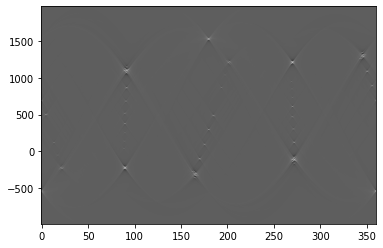

In [ ]:
plt.imshow(radonV2, cmap=plt.cm.Greys_r,extent=(-dx, 360.0 + dx, -dy, radonV2.shape[0] + dy), aspect='auto')

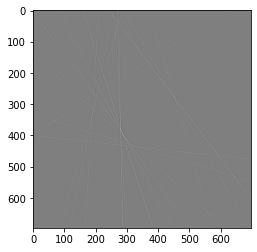

In [ ]:
reconstruction_fbp = iradon(corners, theta=theta2, filter_name='ramp', circle=False)
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)

## Reconstruction with Simultaneous Algebraic Technique

In [ ]:
# from skimage.transform import iradon_sart

# reconstruction_sart = iradon_sart(sinogram, theta=theta1)
# plt.imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

In [ ]:
# cv2.imshow("Reconstruction", reconstruction_sart)
# cv2.waitKey(5000)

## Detect Intersections

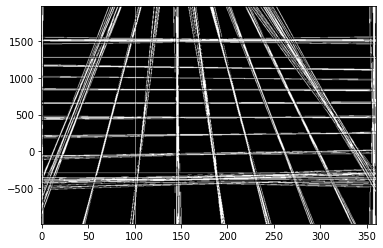

In [ ]:
ret, testImg = cv2.threshold(reconstruction_fbp, 0.03,255,cv2.THRESH_BINARY)
plt.imshow(testImg,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

In [ ]:
#Transpose array and then find intersection between the two matricies

npTestImg = np.asarray(testImg)
npTestImg_T = npTestImg.transpose()


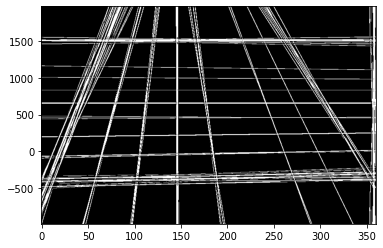

In [ ]:
plt.imshow(npTestImg,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

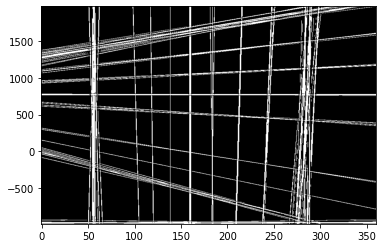

In [ ]:
plt.imshow(npTestImg_T,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

In [ ]:
def printIntersection(A, B) :
 
    for i in range(len(A)) :
        for j in range(len(A[0])) :
 
            # print element value for equal
            # elements else *
            if (A[i][j] == B[i][j]) :
                print(A[i][j], end = " ")
            else :
                print("* ", end = " ")
         
        print()

In [ ]:
def intersect_matrices(mat1, mat2):
    if not (mat1.shape == mat2.shape):
        return False
    
    mat_intersect = np.where((mat1 == mat2), mat1, 0)
    return mat_intersect

In [ ]:
intersection = intersect_matrices(npTestImg, npTestImg_T)

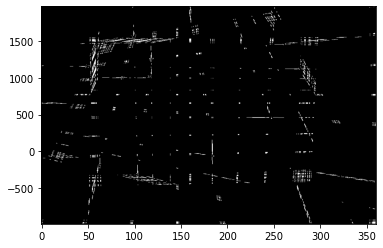

In [ ]:
plt.imshow(intersection,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

## Intersections

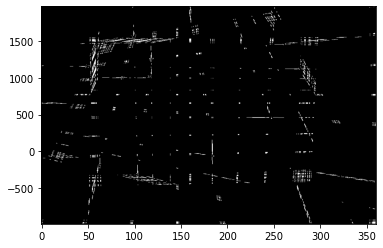

In [ ]:
plt.imshow(intersection,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

# Bentley–Ottmann_algorithm

# Misc For now











## Determine the best position to extract the data from the accumulator matrix

The best position is where the
standard deviation in the horizontal direction is at minimum (i.e. the data is not fragmented and the complete
trend can be seen)

In [ ]:
stdDevX = np.std(sinogram, axis = 0)
stdDevY = np.std(sinogram, axis = 1)

In [ ]:
print(np.where(stdDevX == min(stdDevX)))
print(sinogram[311])

(array([22], dtype=int64),)
[ 37.76470588  54.63612205  48.79685947  46.9611934   44.65136739
  53.4363081   46.89560085  41.21577647  47.0470902   42.61482044
  54.45883924  47.34151066  44.99407585  44.93692642  45.9194796
  36.65758543  45.41137315  31.1366456   32.81898742  45.13801383
  46.6641411   50.69035751  50.33381791  52.9245629   61.29665312
  68.96470842  54.66734952  49.93371415  50.60815199  48.81824018
  38.26459136  46.33539391  50.22809653  48.629602    50.59309086
  55.2955998   51.05779907  56.86781502  52.32205878  43.65393421
  31.71158661  47.96746903  42.18899903  33.487069    39.57905884
  38.35760205  46.76020857  43.48059292  31.7422668   34.26628942
  36.77615346  38.98127712  42.96493168  42.29004944  38.59020032
  34.85754761  33.18276482  46.72365416  49.38965808  35.95225573
  41.24936218  36.05313945  28.00812987  22.68778619  24.96446479
  18.79024396  18.06736931  19.71297726  26.57075266  25.05595158
  23.52028362  25.34722857  24.1137882   31.38934

In [ ]:
# min_x = []
# min_std_Y = np.where(stdDevY == min(stdDevY))

# for x in range(len(sinogram)):
#     min_x.append([x, float(sinogram[x][min_std_Y])])

IndexError: index 914 is out of bounds for axis 0 with size 696

using the estimated points from the previous step, a best line fit can
be used to refine the result